# **Extraction et analyse des catégories de produits**

Ce notebook est spécialisé sur l'extraction et l'analyse des catégories de produits.

Ces catégories donnent notamment les *classes réelles* qui vont nous servir à évaluer les performances du système de classification automatique.

Les catégories sont données dans la variable `product_category_tree` structurée sous forme de tuples représentant des branches (ou chemins par analogie avec l'arborescence d'un système de fichiers) d'un arbre de catégories imbriquées.

# Chargement et visualisation des données

Les tuples sont donnés sous la forme de chaînes de caractères au format suivant :

    '["Cat_1 >> Cat_2 >> .. >> Cat_n"]'

Il faut donc commencer par les *parser* pour en extraire un tuple de mots.

In [20]:
from pepper_utils import print_subtitle
from flipkart_utils import get_raw_data, full_show_sample
cats_tree = get_raw_data('product_category_tree')
print_subtitle("product_category_tree head")
display(cats_tree.head())
print_subtitle("product_category_tree sample with details")
full_show_sample(cats_tree)


product_category_tree head


Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    ["Home Furnishing >> Curtains & Accessories >>...
7b72c92c2f6c40268628ec5f14c6d590    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
64d5d4a258243731dc7bbb1eef49ad74    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
d4684dcdc759dd9cdf41504698d737d8    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
6325b6870c54cd47be6ebfbffa620ec7    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object


product_category_tree sample with details


('2971287a1ac427bd98c4778112d20d06',
 '["Kitchen & Dining >> Kitchen Tools >> Kitchen Implements >> Hand Juicers >> JayEnterprise Hand Juicers >> JayEnterprise Plastic Hand Juicer (Multicolor)"]')

('d06bb04b096c77dc3302eaf2db336f96',
 '["Baby Care >> Baby & Kids Gifts >> Photo Frames >> MH Photo Frames"]')

('a41371b2f8859b015031f0d5eda5184c',
 '["Computers >> Laptop Accessories >> USB Gadgets >> 99Gems USB Gadgets"]')

('219b24362655097cb41bf06a0be8ee79',
 '["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]')

('55ce1309b69e1912d2fd60a3ee3f351b',
 '["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Tatvaarts Ethnic"]')

# Vérification d'intégrité

Vérifions que ces chaînes sont bien formées et non ambigües :
* `'["'` et `'"]'` sont respectivement les marqueurs de début et de fin de chaîne
* Ils n'apparaissent nulle part ailleurs dans la chaîne.
* Il y a de 1 à 6 occurrences du sépérateur de mots `' >> '`
* C'est-à-dire de 2 à 7 mots, avec une majorité de branches de 3 mots, puis 4 et 5 mots, et marginalement 2, 6 ou 7 mots.
* On en déduit que les branches de l'arbre de catégories ont une hauteur essentiellement située entre 3 et 5.


start tags ('\["')
# ✔ 1050
# ✘ 0

end tags ('"\]')
# ✔ 1050
# ✘ 0

sep tags (' >> ')
# ✔ 1050
# ✘ 0

word counts


3    368
5    278
4    274
6     70
7     57
2      3
Name: product_category_tree, dtype: int64

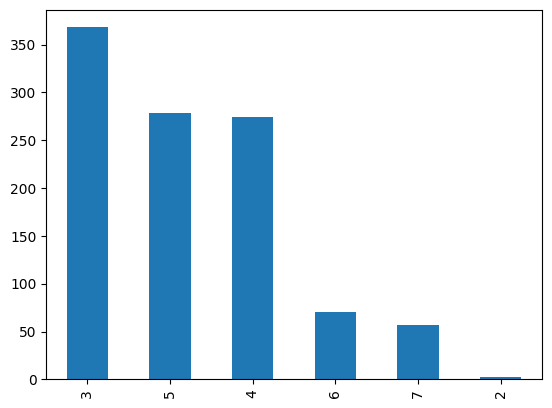

In [32]:
from pepper_utils import print_subtitle
from flipkart_utils import get_raw_data
from tx_prep import count_tag_occurrences
import matplotlib.pyplot as plt

cats_tree = get_raw_data('product_category_tree')

start_tag = '\\["'
end_tag = '"\\]'
sep_tag = " >> "

count_good_start_tag = count_tag_occurrences(cats_tree, f"^{start_tag}")
count_bad_start_tag = count_tag_occurrences(cats_tree, f".{start_tag}|{start_tag}$")
count_good_end_tag = count_tag_occurrences(cats_tree, f"{end_tag}$")
count_bad_end_tag = count_tag_occurrences(cats_tree, f"^{end_tag}|{end_tag}.")
count_good_sep_tag = count_tag_occurrences(cats_tree, f".{sep_tag}.")
count_bad_sep_tag = count_tag_occurrences(cats_tree, f"^{sep_tag}|{sep_tag}$")

print_subtitle(f"start tags ('{start_tag}')")
print("# ✔", count_good_start_tag[count_good_start_tag == 1].shape[0])
print("# ✘", count_bad_start_tag[count_bad_start_tag > 0].shape[0])

print_subtitle(f"end tags ('{end_tag}')")
print("# ✔", count_good_end_tag[count_good_end_tag == 1].shape[0])
print("# ✘", count_bad_end_tag[count_bad_end_tag > 0].shape[0])

print_subtitle(f"sep tags ('{sep_tag}')")
print("# ✔", count_good_sep_tag[count_good_sep_tag > 0].shape[0])
print("# ✘", count_bad_sep_tag[count_bad_sep_tag > 0].shape[0])

print_subtitle(f"word counts")
count_good_sep_tag += 1
display(count_good_sep_tag.value_counts())
count_good_sep_tag.value_counts().plot.bar()
plt.show()

# Découpe et transformation en tuples de mots

In [35]:
from pepper_utils import print_subtitle
from flipkart_utils import get_raw_data, full_show_sample

cats_tree = get_raw_data('product_category_tree')

start_tag = '\\["'
end_tag = '"\\]'
sep_tag = " >> "

tokenized_branches = (
    cats_tree
    .str.replace(f"{start_tag}|{end_tag}", "", regex=True)
    .str.split(sep_tag, regex=True)
)

print_subtitle(f"tokenized cats branches")
display(tokenized_branches.head())

print_subtitle(f"sample with details")
full_show_sample(tokenized_branches, n=3)


tokenized cats branches


Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    [Home Furnishing, Curtains & Accessories, Curt...
7b72c92c2f6c40268628ec5f14c6d590    [Baby Care, Baby Bath & Skin, Baby Bath Towels...
64d5d4a258243731dc7bbb1eef49ad74    [Baby Care, Baby Bath & Skin, Baby Bath Towels...
d4684dcdc759dd9cdf41504698d737d8    [Home Furnishing, Bed Linen, Bedsheets, SANTOS...
6325b6870c54cd47be6ebfbffa620ec7    [Home Furnishing, Bed Linen, Bedsheets, Jaipur...
Name: product_category_tree, dtype: object


sample with details


('70d571a25d37e16d5d5f4e94faccf454',
 ['Home Furnishing', 'Curtains & Accessories', 'Curtains'])

('c44a5dc5b5ebe5b3e0535b7c2b7921e4',
 ['Baby Care',
  'Infant Wear',
  "Baby Boys' Clothes",
  'Polos & T-Shirts',
  'dongli Polos & T-Shirts',
  "dongli Striped Baby Boy's Polo Neck T-Shirt (Pac..."])

('c20bf28cd809790c04e78fdaf47c038f',
 ['Computers', 'Network Components', 'Routers', 'Intex Routers'])

Une version expansée sera plus pratique à utiliser pour recontruire l'arbre.

Il s'agira pour la suite de la fonction `get_product_category_branches()` du module `flipkart_utils`.

In [38]:
from pepper_utils import print_subtitle
from flipkart_utils import get_raw_data, full_show_sample

cats_tree = get_raw_data('product_category_tree')

start_tag = '\\["'
end_tag = '"\\]'
sep_tag = " >> "

tokenized_branches = (
    cats_tree
    .str.replace(f"{start_tag}|{end_tag}", "", regex=True)
    .str.split(sep_tag, regex=True, expand=True)
)
tokenized_branches.index.name = 'id'
tokenized_branches.columns = [f"level_{i}" for i in tokenized_branches.columns]

print_subtitle(f"tokenized cats branches")
display(tokenized_branches.head())


tokenized cats branches


,level_0,level_1,level_2,level_3,level_4,level_5,level_6
id,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None
d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,None,None
6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,None,None


# Distribution des catégories

## Catégories principales

Ce sont les catégories racines (de niveau 0).

On constate qu'elles représentent 7 classes de distribution uniforme à 150 individus par classe (150 x 7 = 1050).

In [43]:
from flipkart_utils import get_product_category_branches
cats = get_product_category_branches()
display(cats["level_0"].value_counts())

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: level_0, dtype: int64

### Construction des étiquettes de classes réelles

Comme indiqué en introduction, les catégories constituent les étiquettes des *classes réelles* qu'il s'agira de comparer aux prédictions du modèle de classification automatique.

Nous créons donc une fonction `get_class_labels(depth=1)` qui retourne une série de labels de classes, par défaut les catégories de niveau 0, et éventuellement davantage (sous forme de tuples de catégories).

In [50]:
cats_cats = cats.astype("category")
display(cats_cats["level_0"].cat.codes)

Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    4
7b72c92c2f6c40268628ec5f14c6d590    0
64d5d4a258243731dc7bbb1eef49ad74    0
d4684dcdc759dd9cdf41504698d737d8    4
6325b6870c54cd47be6ebfbffa620ec7    4
                                   ..
958f54f4c46b53c8a0a9b8167d9140bc    0
fd6cbcc22efb6b761bd564c28928483c    0
5912e037d12774bb73a2048f35a00009    0
c3edc504d1b4f0ba6224fa53a43a7ad6    0
f2f027ad6a6df617c9f125173da71e44    0
Length: 1050, dtype: int8

In [56]:
from flipkart_utils import get_class_labels
display(get_class_labels(depth=3))

,level_0,level_1,level_2
Flipkart,,,
55b85ea15a1536d46b7190ad6fff8ce7,4,19,60
7b72c92c2f6c40268628ec5f14c6d590,0,1,9
64d5d4a258243731dc7bbb1eef49ad74,0,1,9
d4684dcdc759dd9cdf41504698d737d8,4,8,27
6325b6870c54cd47be6ebfbffa620ec7,4,8,27
...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0,0,201
fd6cbcc22efb6b761bd564c28928483c,0,0,201
5912e037d12774bb73a2048f35a00009,0,0,201


In [45]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(cats["level_0"])
display(labels)

1050

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Exemple de données avec une colonne "Catégorie"
df = pd.DataFrame({'Catégorie': ['A', 'B', 'C', 'A', 'B', 'C']})

# Transformation en labels de classes réelles avec LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Catégorie'])

# Affichage des labels
print(labels)

print(label_encoder.inverse_transform([0]))

# Regroupement en tuples avec MultiLabelBinarizer
multi_label_binarizer = MultiLabelBinarizer()
tuples = multi_label_binarizer.fit_transform([list(label_encoder.inverse_transform([label])) for label in labels])

# Affichage des tuples
print(tuples)

[0 1 2 0 1 2]
['A']
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
